# Case de Recomendação usando Market Basket Analysis para Live Class FIAP
# Agosto/2023
## Instrutor: Bruno Curtarelli (Head of Data Science - Petlove & Co)

### Currículo
- Estatística Unicamp
- MBA gestão FIA/PROVAR
- Especializações em Machine Learning e Deep Learning - Andrew Ng (coursera)

### Experiência
- Data Scientist Nielsen
- Head Data Science Behup
- Head Data Science e fundador do primeiro time de dados da Petlove em 2018

Atualmente trabalhando com foco em Planejamento e Ressuprimento, desenvolvendo produtos de dados para previsão de demanda e sugestão de compra, além de robôs para monitorar todo o processo e auxiliar na melhoria contínua dos principais indicadores da companhia

Encontro do time de Digital da Petlove & Co

<img src="bruno.jpg" alt=![bruno.jpg] align="left" width="700" height="700" />

## Contexto do Problema que veremos hoje: e-commerce / varejista

### Dados disponíveis:
- Transações por cliente com lista de produtos

### O que gostaríamos de ter?
- Entender quais produtos são comprados frequentemente juntos
- Quais produtos podem alavancar as vendas de outros produtos

### Como usamos isso na prática?
- Sugerir no carrinho outros produtos para os clientes
- Definir sortimento de página de produtos, colocando produtos correlacionados próximos uns dos outros
- Ações de CRM para impulsionar venda
- Ofertar de forma assertiva produtos para incremento de vendas, vendas cruzadas

# Recomendação de Produtos usando Market Basket Analysis (análise de cesta de produtos)

## Técnica utilizada para descobrir regras de associação de produtos

## Algoritmo - Apriori:
### Método de aprendizado de máquina baseado em regras de associação para encontrar relacionamentos relevantes entre produtos em grandes dimensões de dados. Utiliza conjunto de dados transacionais, como exemplo, lista de produtos comprados por cada cliente numa transação

### Imagine que você disponha de todas as transações (carrinhos) e produtos comprados pelos clientes da sua loja.
### O número de combinações de produtos ou skus/eans são infinitos. Como entender quais combinações (ou associações) de produtos são relevantes, ou mais acontecem?

### Qual é a probabilidade de um produto X ser comprado, dado que o cliente está levando Y?

### Podemos imaginar que um cliente que colocou em seu carrinho macarrão e molho de tomate, também tenha uma alta probabilidade de comprar um queijo ralado, ou talvez um vinho? Quão relevantes são essas associações?

### São estes tipos de perguntas que a análise de cestas pode ajudar a responder

Exemplos de cestas de produtos

<img src="basket.jpg" alt=![basket.jpg] align="left" width="900" height="700" />

## Podemos, por exemplo, entender qual é a probabilidade de um cliente comprar cerveja numa visita ao mercado, uma vez que ele está comprando fraldas?

### -------------------------------------------------------------------------------------------------------------------------------------------------------

## Imagine que os produtos de um mercado estão dispostos em colunas de uma tabela e para cada cesta ou carrinho nas linhas, há uma marcação com 0 e 1 para indicar a ausência ou presença de cada item no respectivo carrinho.

## Esses vetores booleanos podem ser estudados para encontrarmos padrões que indiquem quais produtos são comprados frequentemente juntos. Estes padrões são representados com regras de associações.

### Pacotes iniciais
Posteriormente importaremos os pacotes para aplicação do algoritmo de market basket analysis usando o apyori

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib_venn import venn2, venn3

from IPython.display import Markdown as md

import warnings
warnings.filterwarnings('ignore')

In [2]:
# aqui o produto "carrinhos" serve apenas para contabilizar o espaço amostral dos carrinhos

carts_example = {'carrinho 1':{'pão':1, 'leite':1, 'queijo':1, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 2':{'pão':0, 'leite':0, 'queijo':0, 'fralda':1, 'cerveja':1, 'batata':1, 'carrinhos':1}
                ,'carrinho 3':{'pão':0, 'leite':0, 'queijo':1, 'fralda':1, 'cerveja':1, 'batata':0, 'carrinhos':1}
                ,'carrinho 4':{'pão':1, 'leite':0, 'queijo':1, 'fralda':0, 'cerveja':1, 'batata':0, 'carrinhos':1}
                ,'carrinho 5':{'pão':1, 'leite':0, 'queijo':1, 'fralda':1, 'cerveja':1, 'batata':0, 'carrinhos':1}
                ,'carrinho 6':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 7':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 8':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 9':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                ,'carrinho 10':{'pão':0, 'leite':0, 'queijo':0, 'fralda':0, 'cerveja':0, 'batata':0, 'carrinhos':1}
                }

print(pd.DataFrame(carts_example).T.to_markdown())

|             |   pão |   leite |   queijo |   fralda |   cerveja |   batata |   carrinhos |
|:------------|------:|--------:|---------:|---------:|----------:|---------:|------------:|
| carrinho 1  |     1 |       1 |        1 |        0 |         0 |        0 |           1 |
| carrinho 2  |     0 |       0 |        0 |        1 |         1 |        1 |           1 |
| carrinho 3  |     0 |       0 |        1 |        1 |         1 |        0 |           1 |
| carrinho 4  |     1 |       0 |        1 |        0 |         1 |        0 |           1 |
| carrinho 5  |     1 |       0 |        1 |        1 |         1 |        0 |           1 |
| carrinho 6  |     0 |       0 |        0 |        0 |         0 |        0 |           1 |
| carrinho 7  |     0 |       0 |        0 |        0 |         0 |        0 |           1 |
| carrinho 8  |     0 |       0 |        0 |        0 |         0 |        0 |           1 |
| carrinho 9  |     0 |       0 |        0 |        0 |         0 |   

# Para enteder quais associações de produtos são "interessantes", vamos utilizar 3 métricas, as quais descreveremos à seguir

## Através de gráficos de Venn vamos exemplificar como estas 3 métricas funcionam.
## Imagine que temos 1000 carrinhos e queremos avaliar a associação de Fraldas com Cerveja (O case clássico do Walmart)

### Métrica 1) Support:

Quão frequente a associação acontece no conjunto de dados?

Qual a frequência de carrinhos que possuem  fraldas e cerveja juntos?

$$ Support = {freq(Fralda, Cerveja) \over Carrinhos} $$

### A figura abaixo mostra que dos 1000 carrinhos, 100 possuem a combinação de fralda com cerveja. Logo temos um suporte de 100/1000, ou seja 0.1 de suporte

In [3]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 23}

matplotlib.rc('font', **font)

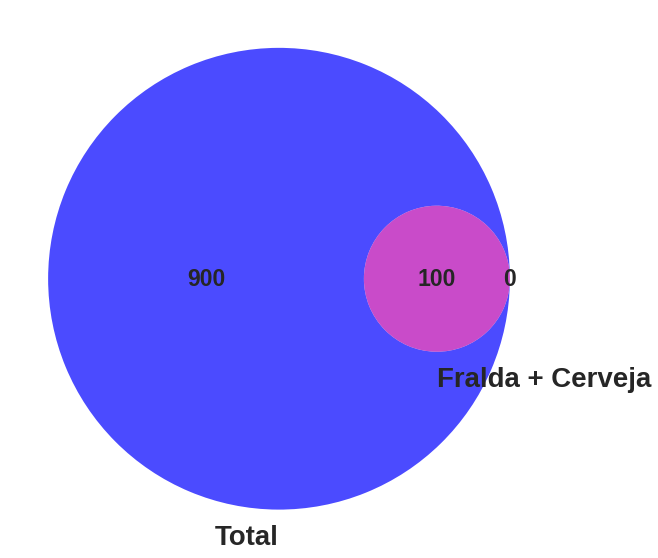

In [4]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn2(
   subsets=(900, 0, 100),
   set_labels=['Total', 'Fralda + Cerveja'],
   alpha = .7,
   set_colors=['blue', 'red']
 )
plt.show()

### Métrica 2) Confidence:

Quão forte é a regra de associação?

Qual é a probabilidade de alguém comprar cerveja dado que ela comprou fralda?

$$ Confidence = {freq(Fralda, Cerveja) \over freq(Fralda)} $$

### Do total de 300 transações que contém Fralda, 100 delas também contém cerveja. Então temos uma confiança de 100/300, ou 0.33

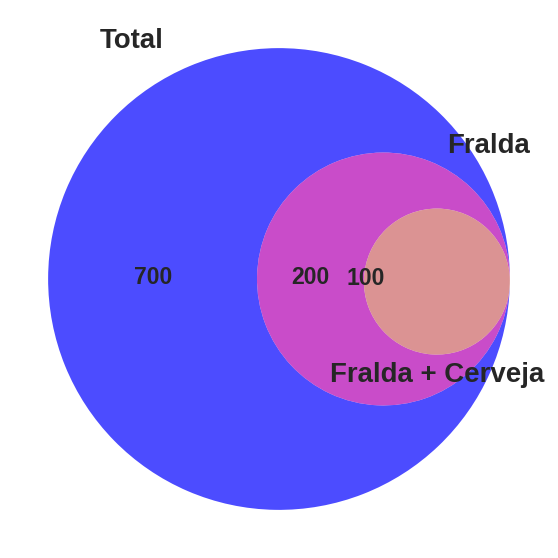

In [5]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(700, 0, 200, 0, 0, 0, 100),
   set_labels=['Total','Fralda','Fralda + Cerveja'],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

### Métrica 3) Lift:

Qual é a performance da regra de associação?

$$ Lift = {{freq(Fralda, Cerveja) \over Carrinhos} \over {{freq(Fralda) \over Carrinhos} {freq(Cerveja) \over Carrinhos}}} $$

### O lift (ou incremental) representa quanto a venda de um produto A pode ser maior ao vender o produto B. Ele pode ser descrito por 2 casos especiais:

1. O item A e o item B (no exemplo Fralda e Cerveja) são independentes, ou seja, a probabilidade de um carrinho conter Fralda e Cerveja é igual a probabilidade de conter fralda ou a probabilidade de conter cerveja. P(A/B) = P(A) ou P(B/A) = P(B)
2. O item A e B são mutuamente exclusivos, então a probabilidade de um carrinho conter Fralda e Cerveja = 0

No Primeiro caso o lift será sempre maior, ou muito próximo a 1. Enquanto o segundo caso o lift é próximo ou muito menor do que 1.

Teorema de Bayes:
https://en.wikipedia.org/wiki/Bayes'_theorem

### Exemplo 1: Probabilidade de comprar Fralda e Cerveja é igual a probabilidade de comprar Fralda x Probabilidade de Comprar Cerveja e a probabilidade de comprar Cerveja é bem alta

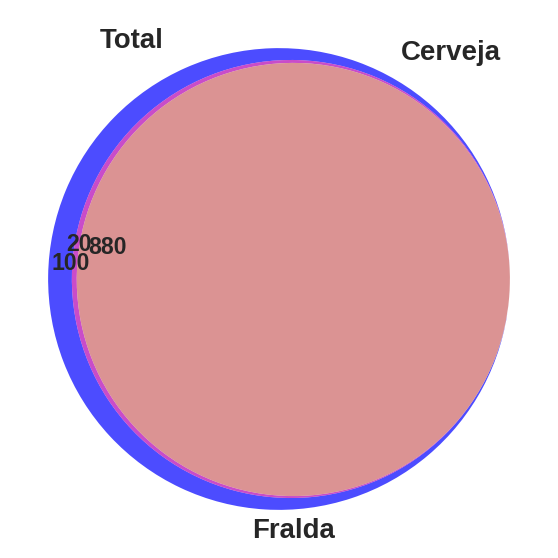

In [6]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(100, 0, 20, 0, 0, 0, 880),
   set_labels=['Total','Cerveja','Fralda'],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

$$ {P(Fralda, Cerveja) \over {P(Fralda) P(Cerveja)}} = {P(Fralda) \over{P(Fralda) P(Cerveja)}} =  {1 \over P(Cerveja)}$$

### Como P(Cerveja) é de 880/1000 = 0.88 e P(Fralda, Cerveja) = P(Fralda), então o lift acaba sendo 1/0.88, ou 1.14

### Exemplo 2: Probabilidade de comprar Fralda e Cerveja é igual a probabilidade de comprar Fralda x Probabilidade de Comprar Cerveja e a probabilidade de comprar Cerveja é bem baixa

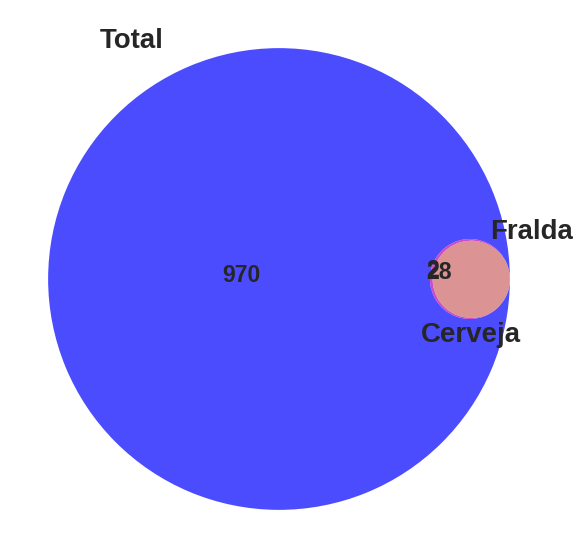

In [37]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(970, 0, 2, 0, 0, 0, 28),
   set_labels=['Total','Fralda','Cerveja'],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

### Como P(Fralda) é de 30/1000 = 0.03 e P(Fralda, Cerveja) = P(Fralda), então o lift acaba sendo 1/0.03, ou 33.3. Em outras palavras, comprar cerveja é bem raro, mas quando ela acontece, Fralda acaba acontecendo junto também.

### Exemplo 3: Probabilidade de comprar Fralda e Cerveja é bem pequena ou quase nem existe

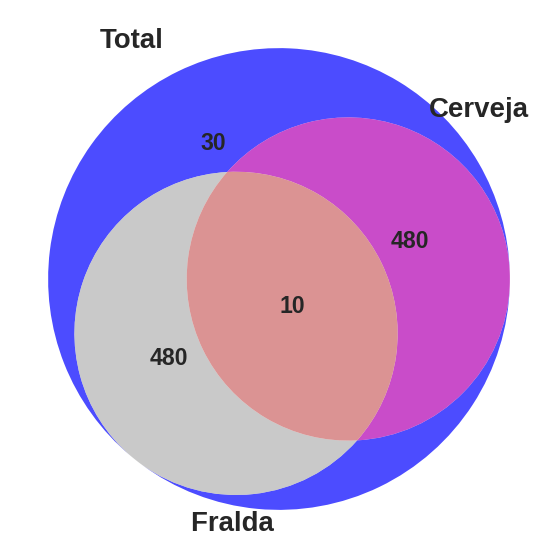

In [8]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(30, 0, 480, 0, 480, 0, 10),
   set_labels=['Total','Cerveja','Fralda '],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

### P(Fralda, Cerveja) = 10/1000 = 0.01. A P(Fralda) = 490/1000 = 0.49 e P(Cerveja) = 490/1000 = 0.49 também.
### Logo o lift seria 0.01/0.24 = 0.04, ou seja, um valor bem abaixo de 1

### Exemplo 4: Probabilidade de comprar Fralda e Cerveja é bem pequena ou quase nem existe e a probabilidade de comprar cerveja é baixa

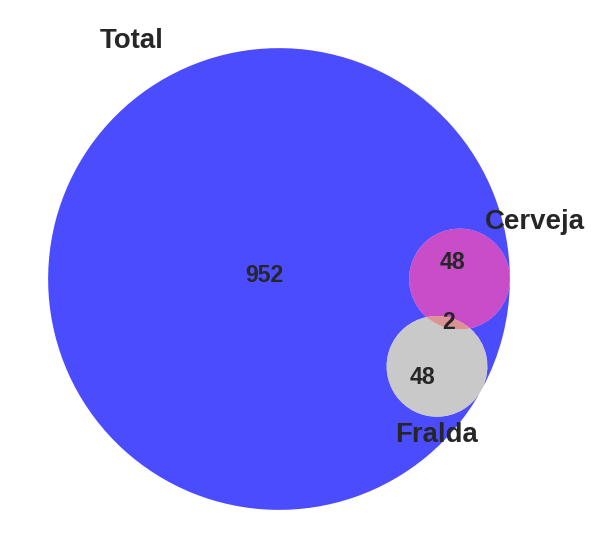

In [9]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
venn3(
    # (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
    subsets=(952, 0, 48, 0, 48, 0, 2),
   set_labels=['Total','Cerveja','Fralda'],
    alpha = .7,
    set_colors=['blue', 'red', 'yellow']
 )
plt.show()

### P(Fralda, Cerveja) = 2/1000 = 0.002. A P(Fralda) = 50/1000 = 0.05 e P(Cerveja) = 50/1000 = 0.05 também.
### Logo o lift seria 0.002 / 0.0025, ou seja, um valor bem próximo de 1, ou seja, sem incrementalidade

## Em Resumo:
### Queremos encontrar associações "raras" e com uma alta correlação

In [10]:
lift_example = [{'sobreposição':'alta', 'probabilidade':'alta', 'lift': '~1'},
                {'sobreposição':'alta', 'probabilidade':'baixa', 'lift': 'Grande'},
                {'sobreposição':'baixa', 'probabilidade':'alta', 'lift': 'Pequeno'},
                {'sobreposição':'baixa', 'probabilidade':'baixa', 'lift': '~1'},
               ]
print(pd.DataFrame(lift_example).groupby(['sobreposição', 'probabilidade']).last().unstack())

                  lift        
probabilidade     alta   baixa
sobreposição                  
alta                ~1  Grande
baixa          Pequeno      ~1


# Combinações de Produtos entre todos os Carrinhos

In [11]:
ab = pd.DataFrame(carts_example)
# print(ab.to_markdown())

ab_melt = ab.reset_index().melt(id_vars='index')

carts = {}
products ={}
for p in pd.unique(ab_melt['index']):
    products[p] = set(ab_melt.loc[(ab_melt['index']==p) & (ab_melt['value']==1)]['variable'].tolist())

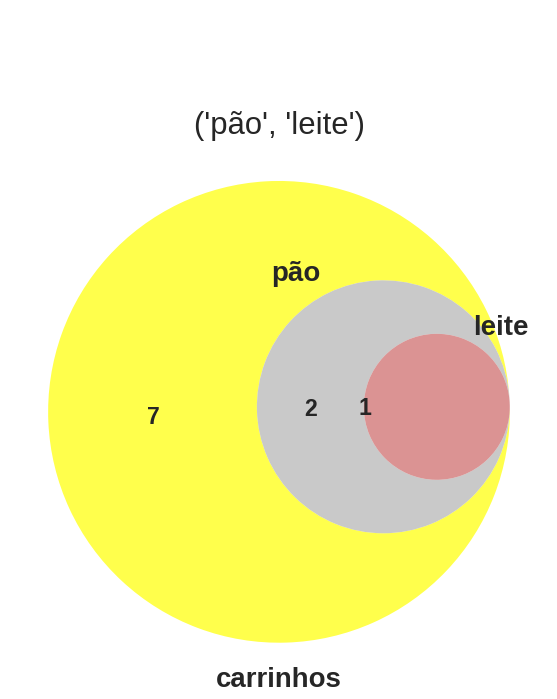

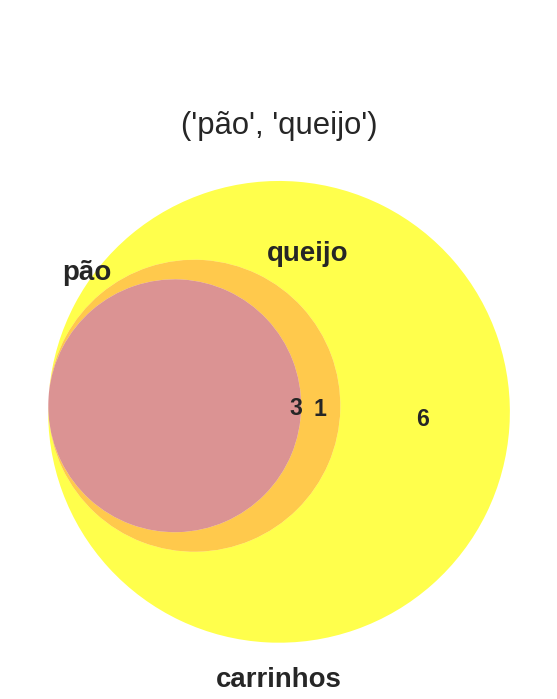

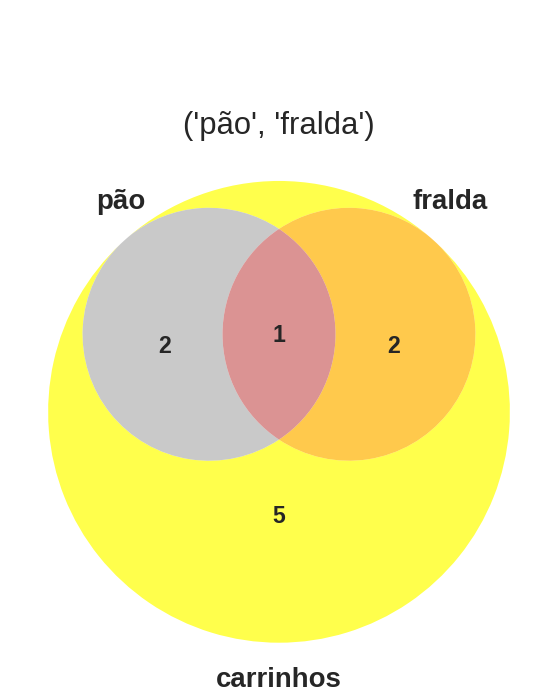

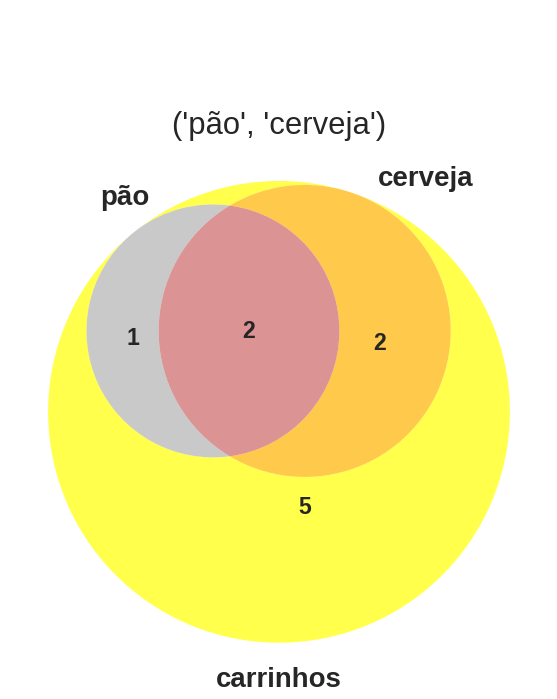

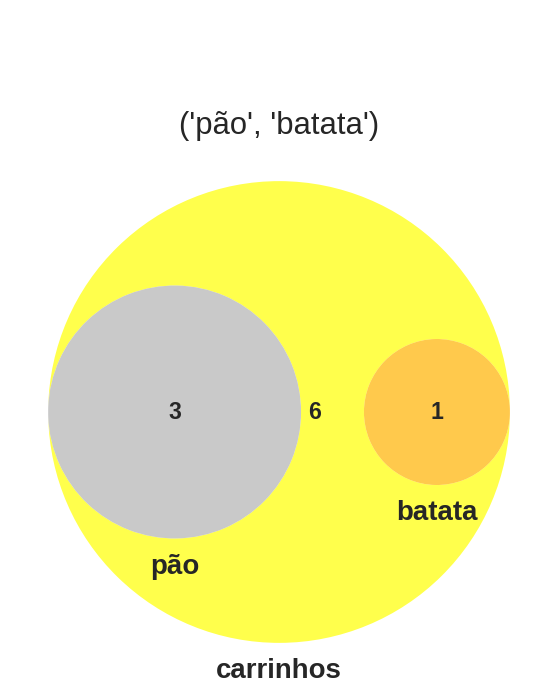

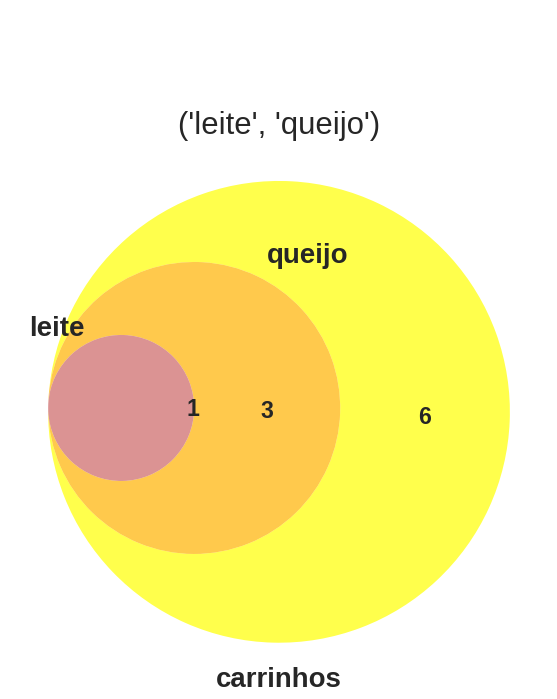

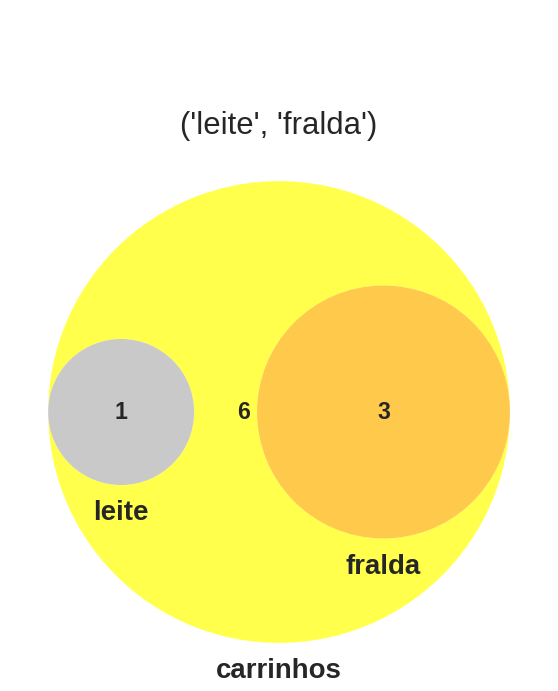

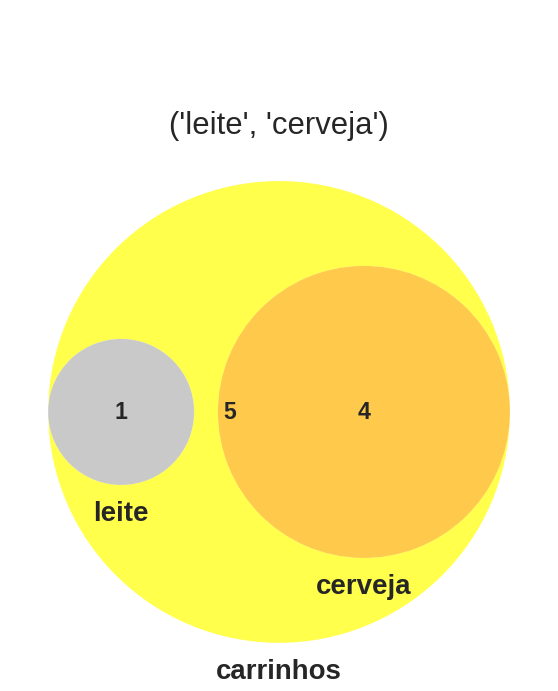

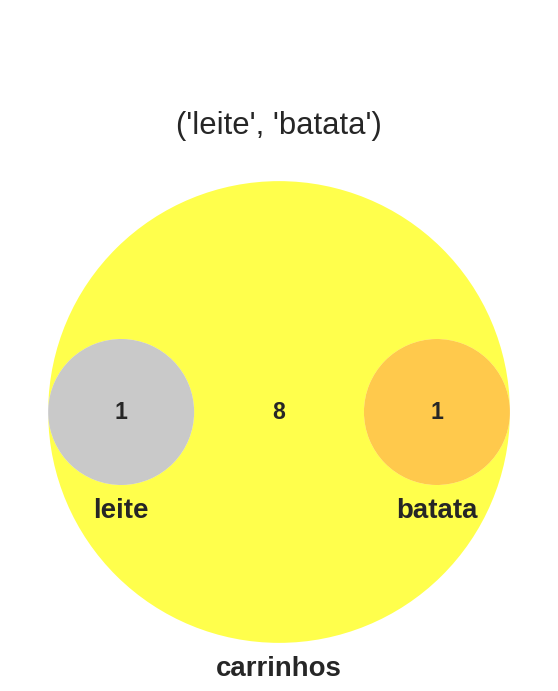

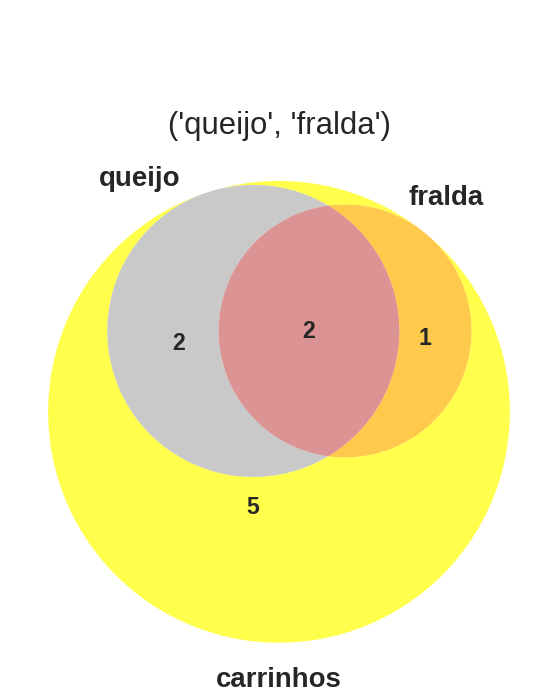

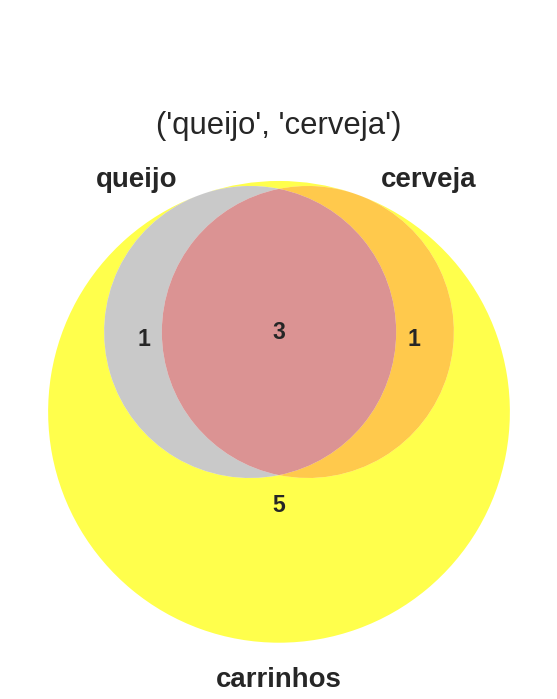

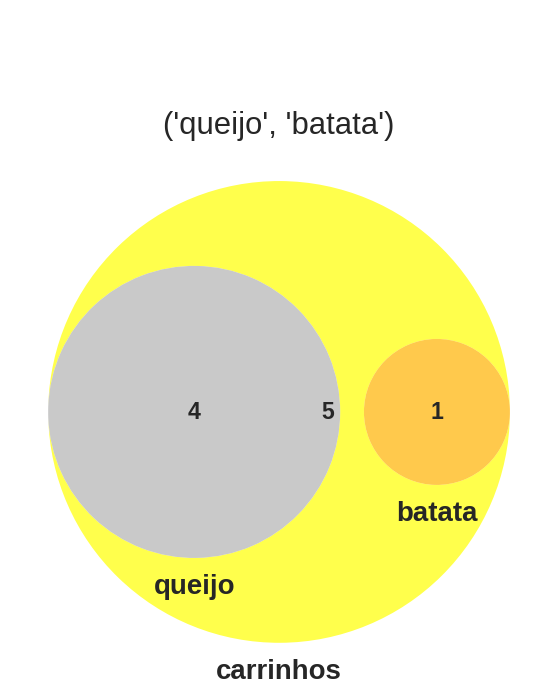

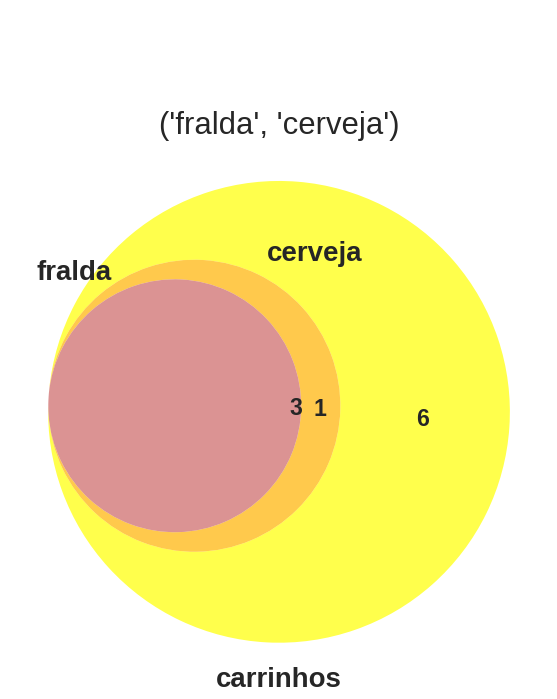

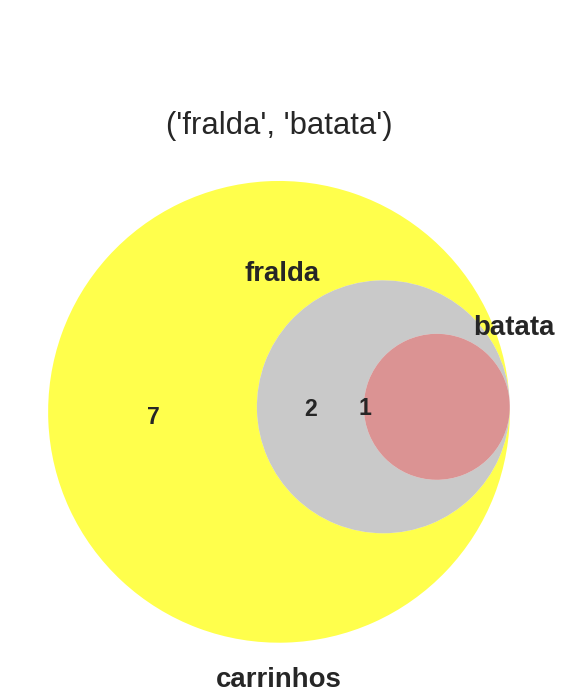

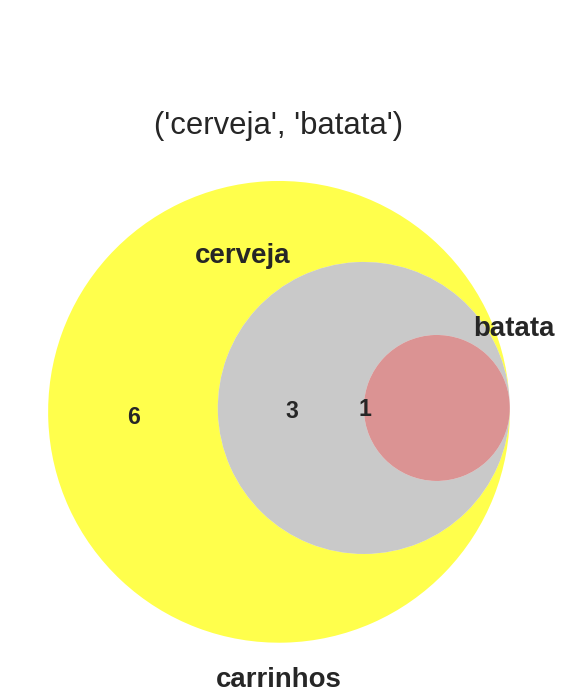

In [12]:
# para pegar as combinações - itertools
import itertools

combs = list(itertools.combinations([item for item in ab.index if item not in 'carrinhos'], 2))

for i in range(len(combs)):
    plt.figure(figsize=(15,10))
    plt.style.use('seaborn')
    plt.title(str('\n\n\n')+str(combs[i]), fontsize=31)
    venn3(
        [products[combs[i][0]], products[combs[i][1]], products['carrinhos']],
       set_labels=combs[i]+('carrinhos',),
        alpha = .7,
        set_colors=['blue', 'red', 'yellow']
     )
    plt.show()

# Agora vamos para a prática!

### Leitura dos dados
Obtidos em:

https://www.kaggle.com/datasets/sivaram1987/association-rule-learningapriori?resource=download

In [13]:
df = pd.read_csv('Market_Basket_Optimisation.csv', low_memory=False, header=None)

### Descrição dos Dados

Matriz de transações x produtos

- Cada linha representa a lista de produtos comprados em cada transação

In [14]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Top 10 produtos mais comprados

In [15]:
df.melt().groupby('value').count().sort_values('variable', ascending=False).head(10)

,variable
value,
mineral water,1788
eggs,1348
spaghetti,1306
french fries,1282
chocolate,1230
green tea,991
milk,972
ground beef,737
frozen vegetables,715


### A quantidade de itens no pedido é em média de 3.9 produtos

In [16]:
items = pd.DataFrame(index=df.index)
items['items_per_order']=df.groupby(df.index).apply(lambda x: x.count(axis=1)).values

In [17]:
items['items_per_order'].mean()

3.914544727369684

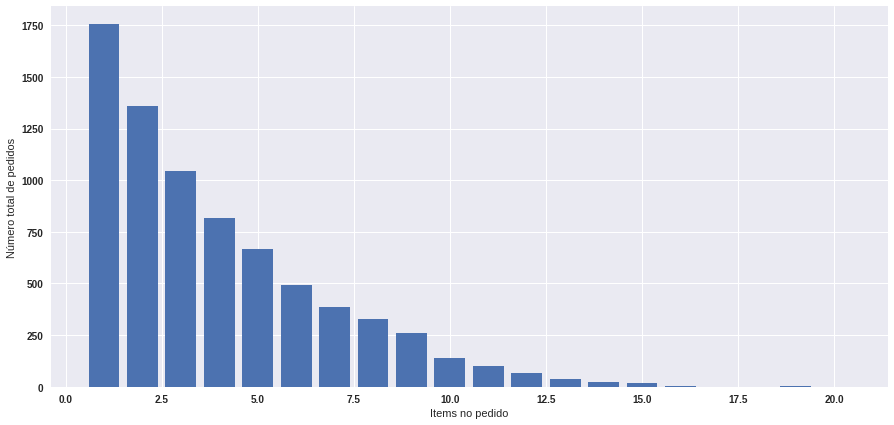

In [18]:
barplot_items = items.reset_index().groupby('items_per_order').count()
plt.figure(figsize=(15,7))
plt.bar(barplot_items.index, barplot_items['index'])
plt.xlabel("Items no pedido")
plt.ylabel("Número total de pedidos")
plt.show()

## Temos 120 produtos distintos entre 7501 transações

In [19]:
orders_products = df.reset_index().melt(id_vars='index')
orders_products.drop('variable', axis=1, inplace=True)
orders_products.columns = ['order', 'product']

In [20]:
# produtos distintos
orders_products['product'].nunique()

120

In [21]:
# transações distintas
orders_products['order'].nunique()

7501

In [38]:
orders_products.head()

,order,product
0,0,shrimp
1,1,burgers
2,2,chutney
3,3,turkey
4,4,mineral water


## Análise de incrementalidade de pedidos a cada produto adicionado ao portfolio

In [22]:
products = orders_products.groupby('product').nunique().reset_index()
products.columns = ['product', 'number_of_orders']
products = products.sort_values('number_of_orders', ascending = False)

In [39]:
products

,product,number_of_orders,complete_orders
72,mineral water,1788,0.0
37,eggs,1348,93.0
100,spaghetti,1306,194.0
43,french fries,1282,259.0
25,chocolate,1229,420.0
...,...,...,...
11,bramble,14,7471.0
34,cream,7,7485.0
77,napkins,5,7492.0
112,water spray,3,7497.0


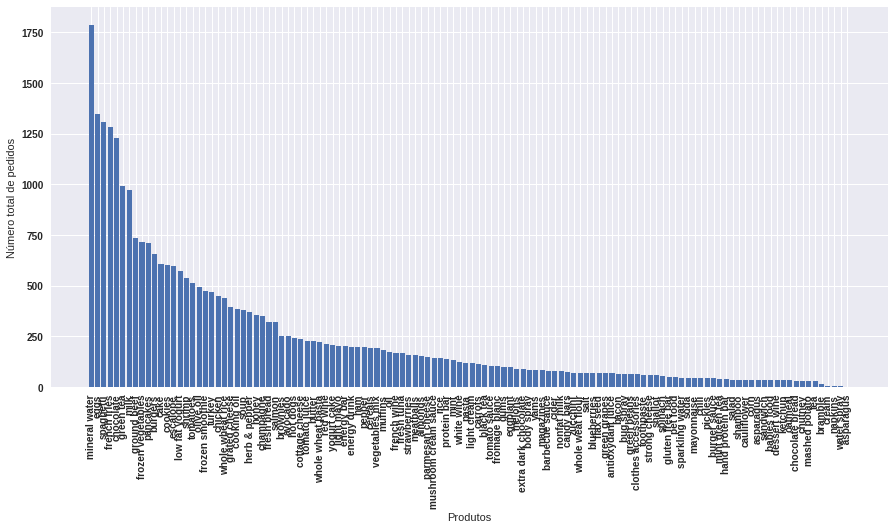

In [23]:
plt.figure(figsize=(15,7))
plt.bar(products['product'], products['number_of_orders'])
plt.xlabel("Produtos")
plt.xticks(rotation=90)
plt.ylabel("Número total de pedidos")
plt.show()

In [24]:
for p in products.index:
    products_notin = products.loc[p:,'product'].values.tolist()
    orders_notin = pd.unique(orders_products.loc[orders_products['product'].isin(products_notin),'order'])
    products.loc[p, 'complete_orders'] = orders_products.loc[~orders_products['order'].isin(orders_notin),'order'].nunique()

In [25]:
products

,product,number_of_orders,complete_orders
72,mineral water,1788,0.0
37,eggs,1348,93.0
100,spaghetti,1306,194.0
43,french fries,1282,259.0
25,chocolate,1229,420.0
...,...,...,...
11,bramble,14,7471.0
34,cream,7,7485.0
77,napkins,5,7492.0
112,water spray,3,7497.0


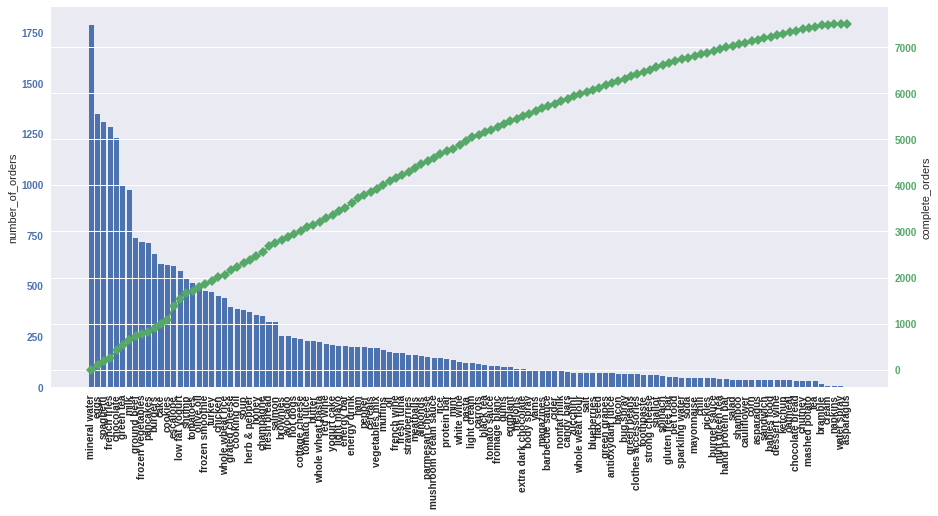

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(products['product'], products['number_of_orders'], color="C0")
ax2 = ax.twinx()
ax2.plot(products['product'], products['complete_orders'], color="C1", marker="D", ms=7)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax.set_xticklabels(products['product'],rotation=90)
ax.set_ylabel('number_of_orders')
ax2.set_ylabel('complete_orders')
ax.grid(False)
plt.show()

## Criando a lista com todos os produtos de cada transação

In [93]:
df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,butter,light mayo,fresh bread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,burgers,frozen vegetables,eggs,french fries,magazines,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,chicken,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7499,escalope,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
lista = []
for i in range(1,len(df)):
    lista.append([str(df.values[i,j]) for j in range(0,20) if df.values[i,j] is not np.nan])

### Exemplos de 10 transações com suas listas de produtos

In [41]:
lista[1:10]

[['chutney'],
 ['turkey', 'avocado'],
 ['mineral water', 'milk', 'energy bar', 'whole wheat rice', 'green tea'],
 ['low fat yogurt'],
 ['whole wheat pasta', 'french fries'],
 ['soup', 'light cream', 'shallot'],
 ['frozen vegetables', 'spaghetti', 'green tea'],
 ['french fries'],
 ['eggs', 'pet food']]

## Aplicando o método Apriori

https://github.com/ymoch/apyori

https://zaxrosenberg.com/unofficial-apyori-documentation/

https://pypi.org/project/apyori/

In [57]:
from apyori import apriori

arules = apriori(lista, min_support=0.01, min_confidence=0.2, min_lift=2)
results = list(arules)

In [58]:
len(results)

20

In [79]:
results[0]

RelationRecord(items=frozenset({'frozen vegetables', 'shrimp'}), support=0.016666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset({'shrimp'}), items_add=frozenset({'frozen vegetables'}), confidence=0.2336448598130841, lift=2.4508202078295533)])

In [31]:
ItemBase = []
ItemAdd = []
Support = []
Confidence = []
Lift = []

for i in results:
    
    relacao = i[2]
    
    for r in range(len(relacao)):
        ItemBase.append(relacao[r][0])
        ItemAdd.append(relacao[r][1])
        Support.append(i[1])
        Confidence.append(relacao[r][2])
        Lift.append(relacao[r][3])
        
dict = {'ItemBase': ItemBase, 'ItemAdd':ItemAdd, 'Support': Support, 'Confidence': Confidence, "Lift": Lift} 
apriori_df_results = pd.DataFrame(dict)

In [78]:
apriori_df_results

,ItemBase,ItemAdd,Support,Confidence,Lift
0,(shrimp),(frozen vegetables),0.016667,0.233645,2.450820
1,(tomatoes),(frozen vegetables),0.016133,0.235867,2.474134
2,(grated cheese),(ground beef),0.011333,0.216285,2.201001
3,(herb & pepper),(ground beef),0.016000,0.323450,3.291555
4,(olive oil),(ground beef),0.014133,0.215010,2.188027
5,(ground beef),(spaghetti),0.039200,0.398915,2.290857
6,(spaghetti),(ground beef),0.039200,0.225115,2.290857
7,(olive oil),(milk),0.017067,0.259635,2.003356
8,(soup),(milk),0.015200,0.300792,2.320923
9,(olive oil),(spaghetti),0.022933,0.348884,2.003547


## Visualizando a distribuição dos resultados pela Confiança, Support e Lift

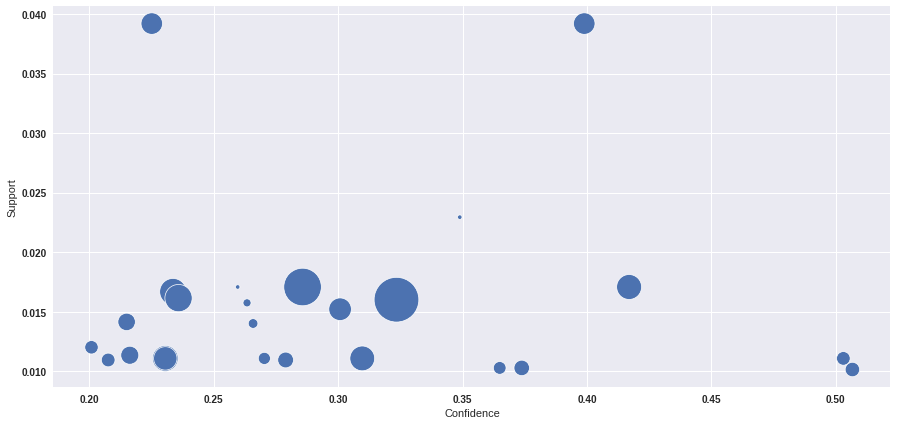

In [36]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=apriori_df_results, x="Confidence", y="Support", size="Lift", legend=False, sizes=(20, 2000))
plt.show()

# Conclusão

### Com os resultados obtidos seria possível selecionar clientes que possuem combinações de itens base (ItemBase) relevantes e recomendar itens para serem adicionados em sua compra (ItemAdd), conforme as combinações e lifts apresentados no dataframe apriori_df_results

### Podemos pensar em implementações mais simples, via CRM, email marketing, push notification, até mesmo em automações mais sofisticadas, com os resultados dessa modelagem fornecendo via API as recomendações para a plataforma do seu site, no carrinho, usando os produtos que já estão na cesta como base, ou então usando a busca como base

### Alguns artigos e posts sobre o tema

https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-market-basket-analysis/

https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce

https://techbusinessguide.com/what-is-lift-in-market-basket-analysis/

https://www.thedataschool.co.uk/liu-zhang/understanding-lift-for-market-basket-analysis